# Задача 7. Нейронные сети

* **Дедлайн**: 28.03.2025, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- Найти данные в виде изображений для задачи классификации. Например, можно взять данные [отсюда](http://ufldl.stanford.edu/housenumbers/).
- Реализовать классы, необходимые для построения сети со следующими слоями
	- FullyConnectedLayer
	- ReluLayer
	- FullyConnectedLayer
- Использовать CrossEntropyLoss и L2-регуляризацию.
- Обучить модель на тренировочных данных, подбирать параметры (особенно learning rate) на валидационной и оценить качество на тестовой. Анализировать графики train/val loss, проверять на каждом шаге корректность вычисления градиентов с помощью разностной оценки.
- (**+2 балла**) Добавить Batch normalization.
- (**+2 балла**) В качестве оптимизатор использовать один из: Momentum, RMSprop.
- (**+1 балл**) Также реализовать оптимизатор Adam.

## Dataset
The **SVHN (Street View House Numbers)** dataset is a large-scale image dataset consisting of color images of house numbers (digits 0-9) obtained from Google Street View images. It is often used for benchmarking machine learning models, particularly in the field of digit recognition.

### Key Details:
- **Content**: The dataset contains real-world images of house numbers taken from Street View. The numbers are captured in varying conditions, such as different orientations, sizes, and lighting conditions.
- **Size**:
  - **Training Set**: 73,257 labeled images.
  - **Test Set**: 26,032 labeled images.
  - **Image Dimensions**: The images are 32x32 pixels in size.
- **Labels**: Each image contains a single digit (0-9) representing a house number.
- **Challenges**: The dataset poses challenges due to the variability of the digits' positions, scales, and backgrounds in the images, making it a useful dataset for testing and improving models' robustness in real-world scenarios.


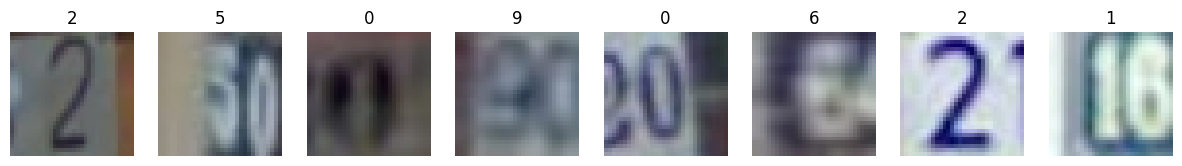

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split
from itertools import product
import torch.nn as nn
import torchmetrics
from tqdm import tqdm
import torch.optim as optim

# Define transformations to convert images to tensors and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the SVHN dataset
trainset = torchvision.datasets.SVHN(root='./svhn-dataset', split='train', download=True, transform=transform)
testset = torchvision.datasets.SVHN(root='./svhn-dataset', split='test', download=True, transform=transform)

# Split the training data into training and validation sets
val_size = 7000
train_size = len(trainset) - val_size

train_subset, val_subset = random_split(trainset, [train_size, val_size])

# Create data loaders for training, validation, and test sets
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Function to display a grid of images
def display_images(images, labels):
    # Denormalize the images for display
    images = images / 2 + 0.5
    np_images = images.numpy()
    
    # Plot the images
    fig, axes = plt.subplots(1, 8, figsize=(15, 2))
    for i in range(8):
        axes[i].imshow(np.transpose(np_images[i], (1, 2, 0)))
        axes[i].set_title(str(labels[i].item()))  # Display the label as title
        axes[i].axis('off')
    plt.show()

# Get a batch of images and labels from the train loader
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Display the first few images with their labels
display_images(images[:8], labels[:8])

## Implementation of layers and neural network

In [6]:
# Define the device (CUDA if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fully connected layer with custom trainable parameters
class CustomLinear(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.W = nn.Parameter(torch.randn(out_dim, in_dim) * 0.01)
        self.b = nn.Parameter(torch.zeros(out_dim))

    def forward(self, x):
        return torch.matmul(x, self.W.t()) + self.b

# Simple implementation of the ReLU activation
class CustomReLU(nn.Module):
    def forward(self, x):
        return torch.relu(x)

# Model without Batch Normalization
class SimpleNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = CustomLinear(3 * 32 * 32, 128)
        self.act1 = CustomReLU()
        self.fc2 = CustomLinear(128, 64)
        self.act2 = CustomReLU()
        self.fc3 = CustomLinear(64, 10)

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)  # Flatten the image into a vector
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x

# Model with Batch Normalization
class NetworkWithBN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = CustomLinear(3 * 32 * 32, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.act1 = nn.ReLU()
        self.layer2 = CustomLinear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.act2 = nn.ReLU()
        self.layer3 = CustomLinear(64, 10)

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.layer2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.layer3(x)
        return x
class CustomAdamOptimizer:
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        self.params = list(params)
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.eps = eps
        self.weight_decay = weight_decay
        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]
        self.t = 0

    def step(self):
        self.t += 1
        for i, p in enumerate(self.params):
            if p.grad is None:
                continue
            grad = p.grad.data
            if self.weight_decay:
                grad = grad + self.weight_decay * p.data
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grad ** 2)
            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)
            p.data -= self.lr * m_hat / (torch.sqrt(v_hat) + self.eps)

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.data.zero_()

## Implementation of Adam optimization

In [7]:
# Custom Adam optimizer implementation
class AdamOptimizer:
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        # Initialize optimizer parameters
        self.params = list(params)
        self.lr = lr
        self.betas = betas
        self.eps = eps
        self.weight_decay = weight_decay
        
        # Initialize momentum and velocity terms
        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]
        self.t = 0  # Time step

    def step(self):
        self.t += 1
        beta1, beta2 = self.betas
        
        # Update parameters with Adam algorithm
        for i, param in enumerate(self.params):
            if param.grad is None:
                continue

            grad = param.grad.data
            if self.weight_decay != 0:
                grad += self.weight_decay * param.data
            
            # Update moving averages for momentum (m) and velocity (v)
            self.m[i] = beta1 * self.m[i] + (1 - beta1) * grad
            self.v[i] = beta2 * self.v[i] + (1 - beta2) * (grad ** 2)
            
            # Correct the bias in the moving averages
            m_hat = self.m[i] / (1 - beta1 ** self.t)
            v_hat = self.v[i] / (1 - beta2 ** self.t)
            
            # Update the parameter
            param.data -= self.lr * m_hat / (torch.sqrt(v_hat) + self.eps)

    def zero_grad(self):
        # Clear gradients for all parameters
        for param in self.params:
            if param.grad is not None:
                param.grad.data.zero_()

## Hyperparameter selection

Training SimpleNetwork with optimizer adam at lr=0.001


Epoch 1/10 - Train Loss: 1.3930, Val Loss: 1.0432
Gradient check at epoch 1:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 2/10 - Train Loss: 0.8939, Val Loss: 0.7616
Gradient check at epoch 2:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 3/10 - Train Loss: 0.7581, Val Loss: 0.7325
Gradient check at epoch 3:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 4/10 - Train Loss: 0.6827, Val Loss: 0.6606
Gradient check at epoch 4:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 5/10 - Train Loss: 0.6361, Val Loss: 0.6704
Gradient check at epoch 5:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 6/10 - Train Loss: 0.5989, Val Loss: 0.6470
Gradient check at epoch 6:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 7/10 - Train Loss: 0.5676, Val Loss: 0.6703
Gradient check at epoch 7:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 8/10 - Train Loss: 0.5438, Val Loss: 0.6157
Gradient check at epoch 8:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 9/10 - Train Loss: 0.5215, Val Loss: 0.6231
Gradient check at epoch 9:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 10/10 - Train Loss: 0.5033, Val Loss: 0.6305
Gradient check at epoch 10:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


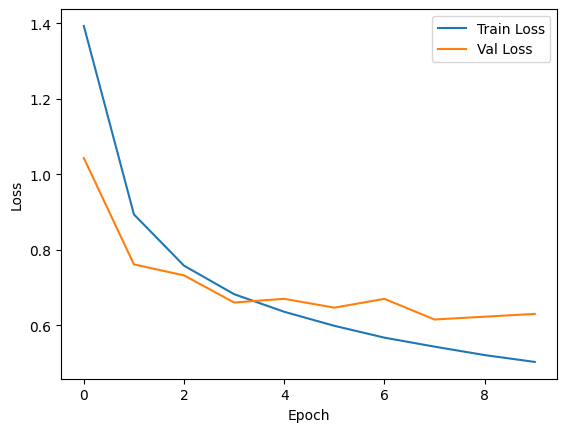

Training SimpleNetwork with optimizer rmsprop at lr=0.001


Epoch 1/10 - Train Loss: 0.5598, Val Loss: 0.6506
Gradient check at epoch 1:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 2/10 - Train Loss: 0.4998, Val Loss: 0.6628
Gradient check at epoch 2:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 3/10 - Train Loss: 0.4844, Val Loss: 0.8256
Gradient check at epoch 3:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 4/10 - Train Loss: 0.4710, Val Loss: 1.0031
Gradient check at epoch 4:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 5/10 - Train Loss: 0.4620, Val Loss: 0.8047
Gradient check at epoch 5:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 6/10 - Train Loss: 0.4502, Val Loss: 0.6525
Gradient check at epoch 6:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 7/10 - Train Loss: 0.4392, Val Loss: 0.6784
Gradient check at epoch 7:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 8/10 - Train Loss: 0.4317, Val Loss: 0.8454
Gradient check at epoch 8:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 9/10 - Train Loss: 0.4235, Val Loss: 0.5902
Gradient check at epoch 9:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 10/10 - Train Loss: 0.4172, Val Loss: 0.6600
Gradient check at epoch 10:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


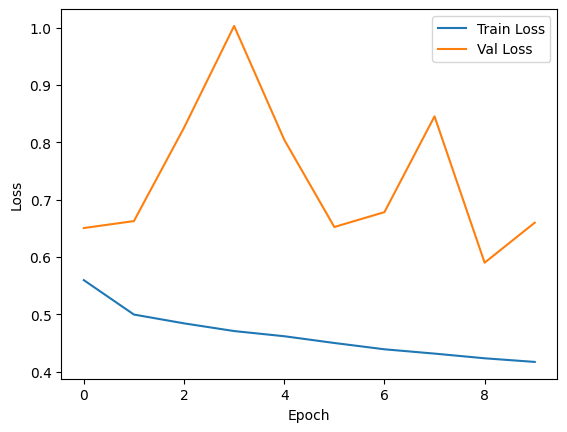

Training SimpleNetwork with optimizer momentum at lr=0.001


Epoch 1/10 - Train Loss: 0.3290, Val Loss: 0.5440
Gradient check at epoch 1:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 2/10 - Train Loss: 0.2978, Val Loss: 0.5445
Gradient check at epoch 2:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 3/10 - Train Loss: 0.2887, Val Loss: 0.5505
Gradient check at epoch 3:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 4/10 - Train Loss: 0.2821, Val Loss: 0.5512
Gradient check at epoch 4:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 5/10 - Train Loss: 0.2780, Val Loss: 0.5551
Gradient check at epoch 5:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 6/10 - Train Loss: 0.2739, Val Loss: 0.5582
Gradient check at epoch 6:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 7/10 - Train Loss: 0.2711, Val Loss: 0.5645
Gradient check at epoch 7:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 8/10 - Train Loss: 0.2689, Val Loss: 0.5628
Gradient check at epoch 8:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 9/10 - Train Loss: 0.2663, Val Loss: 0.5705
Gradient check at epoch 9:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 10/10 - Train Loss: 0.2646, Val Loss: 0.5671
Gradient check at epoch 10:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


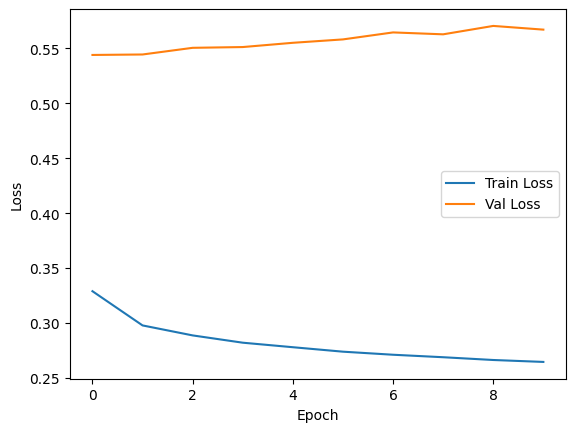

Training SimpleNetwork with optimizer adam at lr=0.01


Epoch 1/10 - Train Loss: 1.4121, Val Loss: 1.2591
Gradient check at epoch 1:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 2/10 - Train Loss: 1.1768, Val Loss: 1.4181
Gradient check at epoch 2:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 3/10 - Train Loss: 1.1574, Val Loss: 1.1527
Gradient check at epoch 3:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 4/10 - Train Loss: 1.1810, Val Loss: 1.2629
Gradient check at epoch 4:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 5/10 - Train Loss: 1.1851, Val Loss: 1.1929
Gradient check at epoch 5:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 6/10 - Train Loss: 1.1945, Val Loss: 1.2027
Gradient check at epoch 6:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 7/10 - Train Loss: 1.2506, Val Loss: 1.3065
Gradient check at epoch 7:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 8/10 - Train Loss: 1.2133, Val Loss: 1.2745
Gradient check at epoch 8:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 9/10 - Train Loss: 1.2308, Val Loss: 1.2753
Gradient check at epoch 9:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 10/10 - Train Loss: 1.2825, Val Loss: 1.3325
Gradient check at epoch 10:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


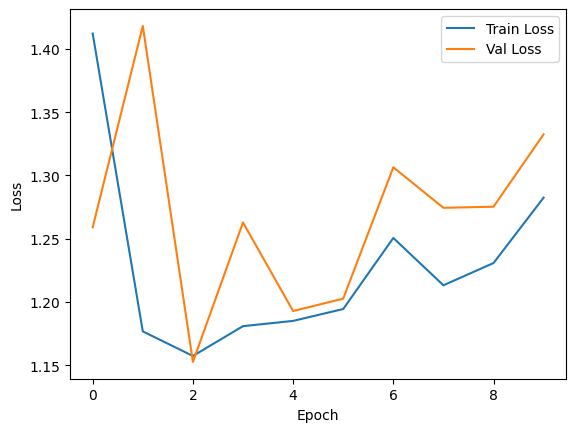

Training SimpleNetwork with optimizer rmsprop at lr=0.01


Epoch 1/10 - Train Loss: 2.1237, Val Loss: 2.1515
Gradient check at epoch 1:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 2/10 - Train Loss: 1.9317, Val Loss: 1.8817
Gradient check at epoch 2:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 3/10 - Train Loss: 1.9377, Val Loss: 1.8398
Gradient check at epoch 3:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 4/10 - Train Loss: 2.0423, Val Loss: 2.1934
Gradient check at epoch 4:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 5/10 - Train Loss: 1.9284, Val Loss: 1.8866
Gradient check at epoch 5:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 6/10 - Train Loss: 1.9404, Val Loss: 1.9603
Gradient check at epoch 6:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 7/10 - Train Loss: 1.9460, Val Loss: 2.0073
Gradient check at epoch 7:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 8/10 - Train Loss: 1.9886, Val Loss: 1.8991
Gradient check at epoch 8:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 9/10 - Train Loss: 1.9285, Val Loss: 2.2818
Gradient check at epoch 9:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 10/10 - Train Loss: 2.1089, Val Loss: 1.8500
Gradient check at epoch 10:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


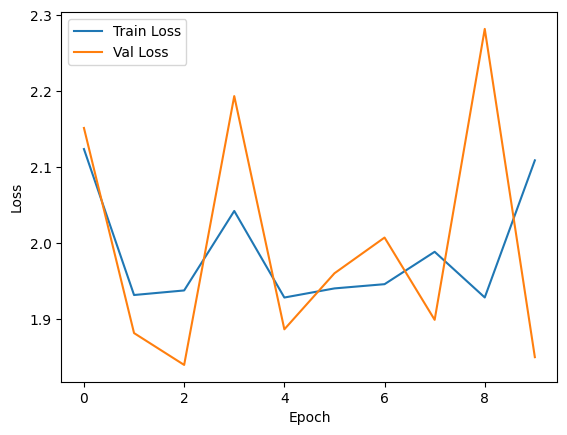

Training SimpleNetwork with optimizer momentum at lr=0.01


Epoch 1/10 - Train Loss: 2.1422, Val Loss: 2.2321
Gradient check at epoch 1:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 2/10 - Train Loss: 2.3354, Val Loss: 2.2102
Gradient check at epoch 2:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 3/10 - Train Loss: 2.2048, Val Loss: 2.2232
Gradient check at epoch 3:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 4/10 - Train Loss: 2.2007, Val Loss: 2.2104
Gradient check at epoch 4:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 5/10 - Train Loss: 2.2194, Val Loss: 2.2261
Gradient check at epoch 5:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 6/10 - Train Loss: 2.2156, Val Loss: 2.2077
Gradient check at epoch 6:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 7/10 - Train Loss: 2.2057, Val Loss: 2.1938
Gradient check at epoch 7:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 8/10 - Train Loss: 2.2010, Val Loss: 2.2224
Gradient check at epoch 8:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 9/10 - Train Loss: 2.2317, Val Loss: 2.2313
Gradient check at epoch 9:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


Epoch 10/10 - Train Loss: 2.2065, Val Loss: 2.2028
Gradient check at epoch 10:
Gradient check passed for fc1.W.
Gradient check passed for fc1.b.
Gradient check passed for fc2.W.
Gradient check passed for fc2.b.
Gradient check passed for fc3.W.
Gradient check passed for fc3.b.


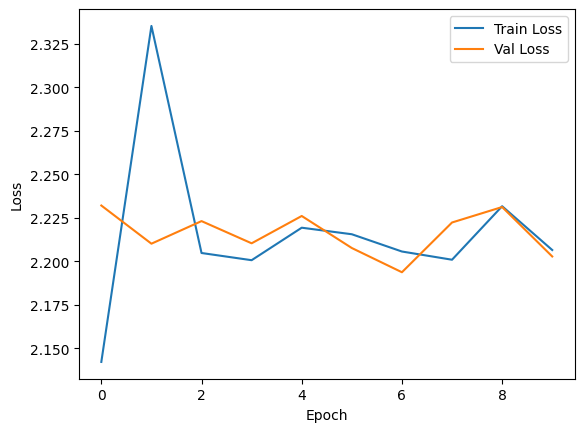

Training NetworkWithBN with optimizer adam at lr=0.001


Epoch 1/10 - Train Loss: 1.3952, Val Loss: 0.9995
Gradient check at epoch 1:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 2/10 - Train Loss: 0.9120, Val Loss: 0.7461
Gradient check at epoch 2:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 3/10 - Train Loss: 0.7710, Val Loss: 0.6814
Gradient check at epoch 3:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 4/10 - Train Loss: 0.7043, Val Loss: 0.6933
Gradient check at epoch 4:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 5/10 - Train Loss: 0.6592, Val Loss: 0.6480
Gradient check at epoch 5:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 6/10 - Train Loss: 0.6314, Val Loss: 0.6612
Gradient check at epoch 6:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 7/10 - Train Loss: 0.6093, Val Loss: 0.6477
Gradient check at epoch 7:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 8/10 - Train Loss: 0.5814, Val Loss: 0.5985
Gradient check at epoch 8:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 9/10 - Train Loss: 0.5698, Val Loss: 0.5662
Gradient check at epoch 9:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 10/10 - Train Loss: 0.5475, Val Loss: 0.5834
Gradient check at epoch 10:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


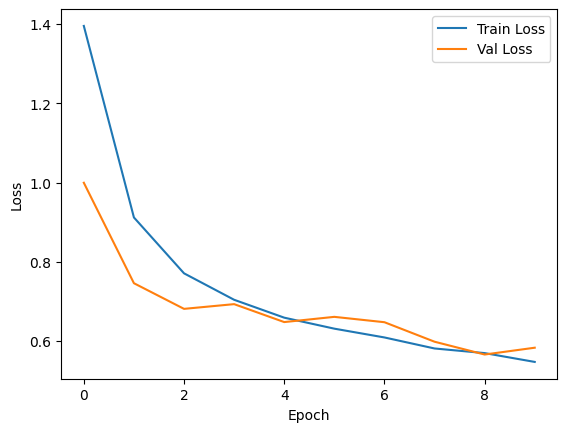

Training NetworkWithBN with optimizer rmsprop at lr=0.001


Epoch 1/10 - Train Loss: 0.5779, Val Loss: 0.5851
Gradient check at epoch 1:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 2/10 - Train Loss: 0.5375, Val Loss: 0.7206
Gradient check at epoch 2:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 3/10 - Train Loss: 0.5242, Val Loss: 0.6655
Gradient check at epoch 3:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 4/10 - Train Loss: 0.5155, Val Loss: 0.7404
Gradient check at epoch 4:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 5/10 - Train Loss: 0.5029, Val Loss: 0.6574
Gradient check at epoch 5:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 6/10 - Train Loss: 0.4932, Val Loss: 0.6139
Gradient check at epoch 6:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 7/10 - Train Loss: 0.4834, Val Loss: 0.6787
Gradient check at epoch 7:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 8/10 - Train Loss: 0.4774, Val Loss: 0.6308
Gradient check at epoch 8:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 9/10 - Train Loss: 0.4649, Val Loss: 0.7354
Gradient check at epoch 9:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 10/10 - Train Loss: 0.4645, Val Loss: 0.5758
Gradient check at epoch 10:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


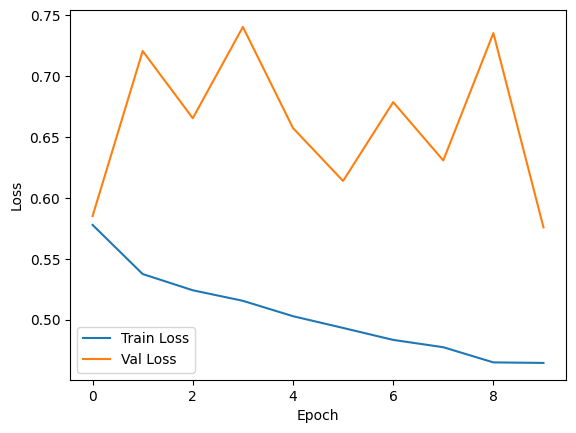

Training NetworkWithBN with optimizer momentum at lr=0.001


Epoch 1/10 - Train Loss: 0.3938, Val Loss: 0.4803
Gradient check at epoch 1:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 2/10 - Train Loss: 0.3710, Val Loss: 0.4773
Gradient check at epoch 2:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 3/10 - Train Loss: 0.3655, Val Loss: 0.4807
Gradient check at epoch 3:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 4/10 - Train Loss: 0.3626, Val Loss: 0.4763
Gradient check at epoch 4:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 5/10 - Train Loss: 0.3565, Val Loss: 0.4853
Gradient check at epoch 5:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 6/10 - Train Loss: 0.3551, Val Loss: 0.4751
Gradient check at epoch 6:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 7/10 - Train Loss: 0.3509, Val Loss: 0.4711
Gradient check at epoch 7:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 8/10 - Train Loss: 0.3507, Val Loss: 0.4711
Gradient check at epoch 8:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 9/10 - Train Loss: 0.3505, Val Loss: 0.4757
Gradient check at epoch 9:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 10/10 - Train Loss: 0.3487, Val Loss: 0.4780
Gradient check at epoch 10:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


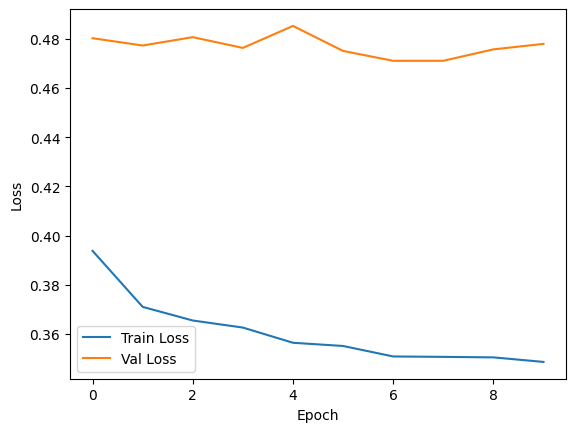

Training NetworkWithBN with optimizer adam at lr=0.01


Epoch 1/10 - Train Loss: 0.9175, Val Loss: 0.8613
Gradient check at epoch 1:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 2/10 - Train Loss: 0.7668, Val Loss: 0.7229
Gradient check at epoch 2:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 3/10 - Train Loss: 0.7033, Val Loss: 0.7094
Gradient check at epoch 3:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 4/10 - Train Loss: 0.6666, Val Loss: 0.6878
Gradient check at epoch 4:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 5/10 - Train Loss: 0.6370, Val Loss: 0.6348
Gradient check at epoch 5:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 6/10 - Train Loss: 0.6165, Val Loss: 0.6102
Gradient check at epoch 6:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 7/10 - Train Loss: 0.5926, Val Loss: 0.6315
Gradient check at epoch 7:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 8/10 - Train Loss: 0.5823, Val Loss: 0.5941
Gradient check at epoch 8:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 9/10 - Train Loss: 0.5639, Val Loss: 0.6391
Gradient check at epoch 9:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 10/10 - Train Loss: 0.5548, Val Loss: 0.6083
Gradient check at epoch 10:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


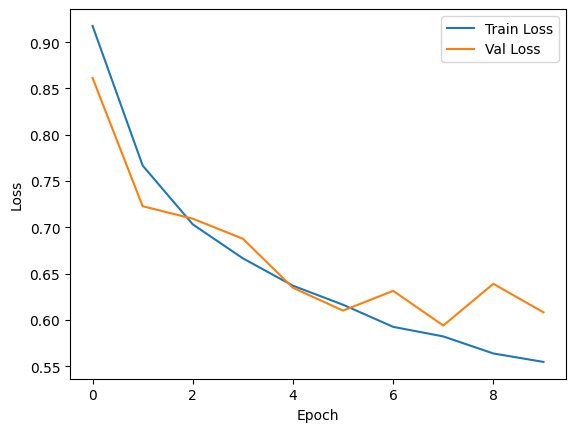

Training NetworkWithBN with optimizer rmsprop at lr=0.01


Epoch 1/10 - Train Loss: 0.5965, Val Loss: 0.7106
Gradient check at epoch 1:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 2/10 - Train Loss: 0.5444, Val Loss: 1.0120
Gradient check at epoch 2:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 3/10 - Train Loss: 0.5319, Val Loss: 1.2169
Gradient check at epoch 3:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 4/10 - Train Loss: 0.5244, Val Loss: 0.7452
Gradient check at epoch 4:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 5/10 - Train Loss: 0.5113, Val Loss: 1.3617
Gradient check at epoch 5:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 6/10 - Train Loss: 0.5027, Val Loss: 0.6166
Gradient check at epoch 6:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 7/10 - Train Loss: 0.4945, Val Loss: 0.7688
Gradient check at epoch 7:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 8/10 - Train Loss: 0.4884, Val Loss: 0.7688
Gradient check at epoch 8:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 9/10 - Train Loss: 0.4814, Val Loss: 0.7381
Gradient check at epoch 9:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 10/10 - Train Loss: 0.4745, Val Loss: 0.6302
Gradient check at epoch 10:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


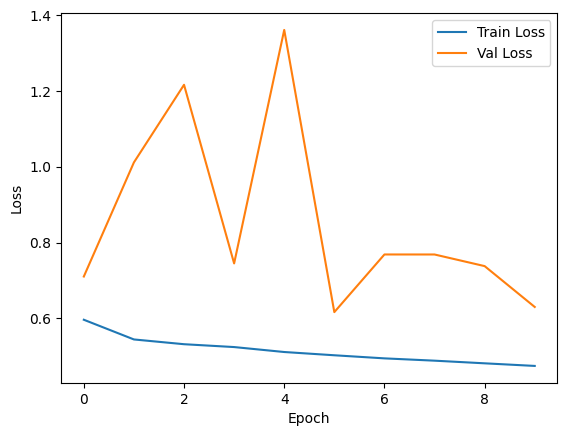

Training NetworkWithBN with optimizer momentum at lr=0.01


Epoch 1/10 - Train Loss: 0.4368, Val Loss: 0.5308
Gradient check at epoch 1:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 2/10 - Train Loss: 0.4073, Val Loss: 0.5166
Gradient check at epoch 2:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 3/10 - Train Loss: 0.3975, Val Loss: 0.5123
Gradient check at epoch 3:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 4/10 - Train Loss: 0.3870, Val Loss: 0.5000
Gradient check at epoch 4:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 5/10 - Train Loss: 0.3817, Val Loss: 0.5036
Gradient check at epoch 5:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 6/10 - Train Loss: 0.3785, Val Loss: 0.4907
Gradient check at epoch 6:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 7/10 - Train Loss: 0.3802, Val Loss: 0.4931
Gradient check at epoch 7:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 8/10 - Train Loss: 0.3696, Val Loss: 0.4884
Gradient check at epoch 8:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 9/10 - Train Loss: 0.3743, Val Loss: 0.4915
Gradient check at epoch 9:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


Epoch 10/10 - Train Loss: 0.3695, Val Loss: 0.4844
Gradient check at epoch 10:
Gradient check passed for layer1.W.
Gradient check passed for layer1.b.
Gradient check passed for bn1.weight.
Gradient check passed for bn1.bias.
Gradient check passed for layer2.W.
Gradient check passed for layer2.b.
Gradient check passed for bn2.weight.
Gradient check passed for bn2.bias.
Gradient check passed for layer3.W.
Gradient check passed for layer3.b.


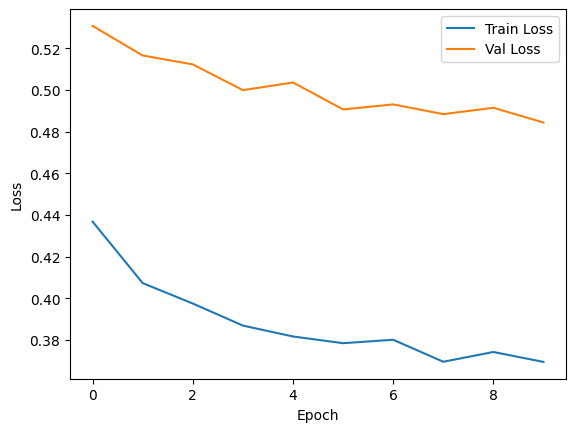

In [8]:
def gradient_check(model, criterion, inputs, labels, epsilon=1e-5, tolerance=1e-4):
    model.eval()
    model.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()

    for name, param in model.named_parameters():
        if param.requires_grad and param.grad is not None:
            analytic_grad = param.grad.clone().detach()
            numerical_grad = torch.zeros_like(param)
            num_checks = min(5, param.numel())
            param_data_flat = param.data.view(-1)
            numerical_grad_flat = numerical_grad.view(-1)
            analytic_grad_flat = analytic_grad.view(-1)
            
            for i in range(num_checks):
                original = param_data_flat[i].item()
                param_data_flat[i] = original + epsilon
                loss_plus = criterion(model(inputs), labels)
                param_data_flat[i] = original - epsilon
                loss_minus = criterion(model(inputs), labels)
                param_data_flat[i] = original

                numerical_grad_flat[i] = (loss_plus - loss_minus) / (2 * epsilon)
            
            diff = torch.norm(analytic_grad_flat[:num_checks] - numerical_grad_flat[:num_checks]) / \
                   (torch.norm(analytic_grad_flat[:num_checks]) + torch.norm(numerical_grad_flat[:num_checks]) + 1e-7)
            if diff.item() > tolerance:
                print(f"WARNING: Gradient check failed for {name}!")
            else:
                print(f"Gradient check passed for {name}.")
    
    model.train()

def run_training(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for batch_x, batch_y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            optimizer.zero_grad()
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            predictions = model(batch_x)
            loss_val = loss_fn(predictions, batch_y)
            loss_val.backward()
            optimizer.step()
            epoch_loss += loss_val.item()
        avg_train = epoch_loss / len(train_loader)
        train_losses.append(avg_train)

        # Validation phase
        model.eval()
        total_val = 0.0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                preds = model(batch_x)
                total_val += loss_fn(preds, batch_y).item()
        avg_val = total_val / len(val_loader)
        val_losses.append(avg_val)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train:.4f}, Val Loss: {avg_val:.4f}")

        # Perform gradient check on a small batch
        sample_x, sample_y = next(iter(train_loader))
        sample_x, sample_y = sample_x[:5].to(device), sample_y[:5].to(device)
        print(f"Gradient check at epoch {epoch+1}:")
        gradient_check(model, loss_fn, sample_x, sample_y)

    return train_losses, val_losses

# Define models, learning rates, and optimizers to test

model_choices = [SimpleNetwork(), NetworkWithBN()]
lr_values = [0.001, 0.01]
optimizers_dict = {
    'adam': lambda params, lr: CustomAdamOptimizer(params, lr=lr),
    'rmsprop': optim.RMSprop,
    'momentum': lambda params, lr: optim.SGD(params, lr=lr, momentum=0.9)
}

results = []

for net_model, lr_val, opt_name in product(model_choices, lr_values, optimizers_dict.keys()):
    net = net_model.to(device)
    criterion = nn.CrossEntropyLoss()
    opt = optimizers_dict[opt_name](net.parameters(), lr=lr_val)
    print(f"Training {net.__class__.__name__} with optimizer {opt_name} at lr={lr_val}")
    tr_losses, vl_losses = run_training(net, trainloader, valloader, criterion, opt, num_epochs=10)

    # Plot the train/validation loss curves
    plt.figure()
    plt.plot(tr_losses, label='Train Loss')
    plt.plot(vl_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    results.append((net, tr_losses, vl_losses, opt_name, lr_val))

In [9]:
best_result = min(results, key=lambda res: res[2][-1])

print(f'Best combination of params is: Model - {best_result[0]}, '
      f'optimizer - {best_result[3]}, lr - {best_result[4]}')
print(f'Best validation loss after 10 epochs - {best_result[2][-1]}')

Best combination of params is: Model - NetworkWithBN(
  (layer1): CustomLinear()
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU()
  (layer2): CustomLinear()
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU()
  (layer3): CustomLinear()
), optimizer - momentum, lr - 0.001
Best validation loss after 10 epochs - 0.4779759481549263


In [10]:
best_model = best_result[0] 
best_optimizer_name = best_result[3]
best_lr = best_result[4]

best_model = best_model.to(device)
criterion = nn.CrossEntropyLoss()
best_optimizer = optimizers_dict[best_optimizer_name](best_model.parameters(), lr=best_lr)

# Define evaluation function
def evaluate_model(model, testloader, device):
    model.eval()
    accuracy_metric = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(device)
    
    # Run evaluation without gradient calculation
    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc="Evaluating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = torch.argmax(outputs, dim=1)
            accuracy_metric.update(predictions, labels)

    print(f"Accuracy of the model on test images: {accuracy_metric.compute() * 100:.10f}%")
    accuracy_metric.reset()  # Reset the metric for future evaluations

# Call evaluation on the best model
evaluate_model(best_model, testloader, device)

Accuracy of the model on test images: 84.3385009766%
